In this project we want to build a predicition model based on regression tehory to predict price of laptop.

### **1-Import libraries**

In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split

from sklearn import set_config
set_config(display="diagram")
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


### **2-Load Data**

In [5]:
path = '/content/drive/MyDrive/Prediction/rawData.csv'

data = pd.read_csv(path)

data.sample(5)

,Company,ProductName,TypeName,ScreenResolution,Cpu,Memory,Gpu,OpSys,Ram,Weight,Inches,Price_euros
559,Dell,Latitude 5480,Notebook,Full HD / 1920x1080,Intel Core i5 7440 2.8GHz,256GB SSD,Intel HD Graphics 620,Windows 10,8GB,1.6kg,14.0,1205.00
713,MSI,GS73VR Stealth,Gaming,IPS Panel Full HD / 1920x1080,Intel Core i7 6700 2.6GHz,256GB SSD,Nvidia GeForce GTX 1060,Windows 10,16GB,2.43kg,17.3,1948.99
230,Apple,"MacBook 12""",Ultrabook,IPS Panel Retina Display / 2304x1440,Intel Core i5 - 6200 1.3GHz,512GB SSD,Intel HD Graphics 615,macOS,8GB,0.92kg,12.0,1510.00
925,Asus,Rog GL753VD-GC042T,Gaming,Full HD / 1920x1080,Intel Core i7 7700 2.8GHz,1000GB HDD,Nvidia GeForce GTX 1050,Windows 10,8GB,3kg,17.3,1039.00
998,Dell,Alienware 17,Gaming,IPS Panel 4K Ultra HD / 3840x2160,Intel Core i7 7700 2.8GHz,256GB SSD,Nvidia GeForce GTX 1070,Windows 10,16GB,4.42kg,15.6,2868.99


### **3-Segregate Data**

In [6]:
#For modelling
df = data.sample(frac=0.8, random_state=42)

#For evaluating
unseen_df = data.drop(df.index)

### **4-Feature Engineering (used in pipeline)**

##### **`Company`**

In [7]:
print(sorted(df['Company'].unique()))

['Acer', 'Apple', 'Asus', 'Chuwi', 'Dell', 'Fujitsu', 'HP', 'Huawei', 'LG', 'Lenovo', 'MSI', 'Mediacom', 'Razer', 'Samsung', 'Toshiba', 'Vero', 'Xiaomi']


##### **`ProductName`**

In [8]:
# Remove Product name

df = df.drop(['ProductName'], axis=1)

##### **`TypeName`**

In [9]:
print(sorted(df['TypeName'].unique()))

['2 in 1 Convertible', 'Gaming', 'Netbook', 'Notebook', 'Ultrabook', 'Workstation']


##### **`ScreenResolution`**

In [10]:
# Add Width and Heigth

def Resolution_Display(display_str):
    pattern = r'\b\d{3,4}x\d{3,4}\b'
    match = re.search(pattern, display_str)
    if match:
        return match.group(0)
    else:
        return 'Other'

df['Resolution Display'] = df['ScreenResolution'].apply(Resolution_Display)
df[['Width(px)', 'Height(px)']] = df['Resolution Display'].str.extract(r'(\d+)x(\d+)').astype(int)
df = df.drop(['Resolution Display'], axis=1)

print(sorted(df['Width(px)'].unique()))
print(sorted(df['Height(px)'].unique()))

[1366, 1440, 1600, 1920, 2160, 2560, 2736, 2880, 3200, 3840]
[768, 900, 1080, 1200, 1440, 1600, 1800, 1824, 2160]


In [11]:
# Add Resolution Quality

def Resolution_Quality(display_str):
    keywords = []
    if '4K Ultra HD' in display_str:
        keywords.append('4K Ultra HD')
    if 'Full HD' in display_str:
        keywords.append('Full HD')
    if 'IPS Panel' in display_str:
        keywords.append('IPS Panel')
    if 'IPS Panel 4K Ultra HD' in display_str:
        keywords.append('IPS Panel 4K Ultra HD')
    if 'IPS Panel Full HD' in display_str:
        keywords.append('IPS Panel Full HD')
    if 'IPS Panel Quad HD+' in display_str:
        keywords.append('IPS Panel Quad HD+')
    if 'IPS Panel Retina Display' in display_str:
        keywords.append('IPS Panel Retina Display')
    if 'Quad HD+' in display_str:
        keywords.append('Quad HD+')
    return ', '.join(keywords) if keywords else 'Other'

df['Resolution_Quality'] = df['ScreenResolution'].apply(Resolution_Quality)

matching_index = df[df['Resolution_Quality'] == '4K Ultra HD, IPS Panel, IPS Panel 4K Ultra HD'].index
desired_text = 'IPS Panel 4K Ultra HD'
df.loc[matching_index, 'Resolution_Quality'] = desired_text

matching_index = df[df['Resolution_Quality'] == 'Full HD, IPS Panel, IPS Panel Full HD'].index
desired_text = 'IPS Panel Full HD'
df.loc[matching_index, 'Resolution_Quality'] = desired_text

matching_index = df[df['Resolution_Quality'] == 'IPS Panel, IPS Panel Quad HD+, Quad HD+'].index
desired_text = 'IPS Panel Quad HD+'
df.loc[matching_index, 'Resolution_Quality'] = desired_text

matching_index = df[df['Resolution_Quality'] == 'IPS Panel, IPS Panel Retina Display'].index
desired_text = 'IPS Panel Retina'
df.loc[matching_index, 'Resolution_Quality'] = desired_text

print(sorted(df['Resolution_Quality'].unique()))

['4K Ultra HD', 'Full HD', 'IPS Panel', 'IPS Panel 4K Ultra HD', 'IPS Panel Full HD', 'IPS Panel Quad HD+', 'IPS Panel Retina', 'Other', 'Quad HD+']


In [12]:
# Add Touchscreen

df['Touchscreen'] = df['ScreenResolution'].apply(lambda x: 'Yes' if 'Touchscreen' in x else 'No')

print(sorted(df['Touchscreen'].unique()))

['No', 'Yes']


In [13]:
# Remove ScreenResolution

df = df.drop('ScreenResolution', axis=1)

##### **`Cpu`**

In [14]:
# Add CPU Type
def CPU_Type (display_str):
    keywords = []
    if 'Atom' in display_str:
        keywords.append('Atom')
    if 'Celeron Dual Core ' in display_str:
        keywords.append('Celeron Dual Core ')
    if 'Intel Core' in display_str:
        keywords.append('Intel Core')
    if 'Pentium' in display_str:
        keywords.append('Intel Pentium Dual Core')
    return ', '.join(keywords) if keywords else 'Other'

df['CPU_Type'] = df['Cpu'].apply(CPU_Type)

print(sorted(df['CPU_Type'].unique()))

['Atom', 'Celeron Dual Core ', 'Intel Core', 'Intel Pentium Dual Core', 'Other']


In [15]:
# Add CPU Strength
def CPU_Strength(description):
    match = re.search(r'\b\d{4}\b', description)
    return match.group(0) if match else None

df['CPU_Strength'] = df['Cpu'].apply(CPU_Strength)
df['CPU_Strength'] = df['CPU_Strength'].astype(int)

print(sorted(df['CPU_Strength'].unique()))

[3050, 3060, 3160, 3205, 3350, 3450, 3700, 3855, 4200, 4405, 6006, 6100, 6200, 6260, 6300, 6440, 6500, 6560, 6600, 6700, 6820, 7100, 7130, 7200, 7300, 7440, 7500, 7560, 7600, 7660, 7700, 7820, 8250, 8300, 8350, 8550]


In [16]:
# Add CPU Hertz
def CPU_Hertz (description):
    match = re.search(r'(\d+\.\d+)GHz', description)
    return float(match.group(1)) if match else None

df['CPU_Hertz(GHz)'] = df['Cpu'].apply(CPU_Hertz)

print(sorted(df['CPU_Hertz(GHz)'].unique()))

[1.1, 1.44, 1.5, 1.6, 1.8, 1.92, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, nan, 2.9, 3.1]


In [17]:
# Drop CPU

df = df.drop('Cpu', axis=1)

##### **`Memory`**

In [18]:
# Add memory Type
def Memory_Type(description):
    match = re.search(r'\d+(\.\d+)?(GB|TB)\s*(.*)', description)
    return match.group(3).strip() if match else None

df['Memory_Type'] = df['Memory'].apply(Memory_Type)

print(sorted(df['Memory_Type'].unique()))

['Flash Storage', 'HDD', 'Hybrid', 'SSD']


In [19]:
# Add memory Capacity
def Memory_Capacity(description):
    match = re.search(r'(\d+(\.\d+)?)\s*(GB|TB)', description)
    return float(match.group(1)) if match else None

df['Memory_Capacity(G)'] = df['Memory'].apply(Memory_Capacity)
df['Memory_Capacity(G)'] = df['Memory_Capacity(G)'].astype(int)

print(sorted(df['Memory_Capacity(G)'].unique()))

[2, 8, 16, 32, 64, 128, 180, 256, 500, 508, 512, 1000]


In [20]:
# Remove Memory

df= df.drop('Memory', axis=1)

##### **`Gpu`**

In [21]:
# Add Gpu Type
def GPU_Type(display_str):
    keywords = []
    if 'FirePro' in display_str:
        keywords.append('AMD FirePro')
    if 'AMD Radeon' in display_str:
        keywords.append('AMD Radeon')
    if 'Intel HD' in display_str:
        keywords.append('Intel HD')
    if 'Iris' in display_str:
        keywords.append('Intel Iris')
    if 'GeForce' in display_str:
        keywords.append('Nvidia GeForce')
    if 'Quadro' in display_str:
        keywords.append('Nvidia Quadro')
    return ', '.join(keywords) if keywords else 'Other'

df['GPU_Type'] = df['Gpu'].apply(GPU_Type)

print(sorted(df['GPU_Type'].unique()))

['AMD FirePro', 'AMD Radeon', 'Intel HD', 'Intel Iris', 'Nvidia GeForce', 'Nvidia Quadro', 'Other']


In [22]:
# Add GPU Strength
def GPU_Strength(description):
    match = re.search(r'(\d+)$', description)
    return int(match.group(1)) if match else None

df['GPU_Strength(GHz)'] = df['Gpu'].apply(GPU_Strength)

print(sorted(df['GPU_Strength(GHz)'].unique()))

[130.0, 150.0, 152.0, 315.0, 330.0, 400.0, 405.0, 420.0, 430.0, 440.0, 445.0, 455.0, 460.0, 465.0, 500.0, 505.0, 510.0, 515.0, 520.0, 530.0, 540.0, 550.0, 560.0, 580.0, 620.0, 630.0, 640.0, 650.0, 920.0, 930.0, 940.0, 950.0, 960.0, 965.0, 970.0, 980.0, 1000.0, 1050.0, 1060.0, 1070.0, 1080.0, 1200.0, 2000.0, 2200.0, 3000.0, 4190.0, 6000.0, nan]


In [23]:
# Remove Gpu

df= df.drop('Gpu', axis=1)

##### **`OpSys`**

In [24]:
print(sorted(df['OpSys'].unique()))

['Android', 'Chrome OS', 'Linux', 'No OS', 'Windows 10', 'Windows 10 S', 'Windows 7', 'macOS']


##### **`Ram`**

In [25]:
# Add RAM
def RAM (description):
    match = re.search(r'(\d+(\.\d+)?)\s*(GB|TB)', description)
    return float(match.group(1)) if match else None

df['RAM(G)'] = df['Ram'].apply(RAM)
df['RAM(G)'] = df['RAM(G)'].astype(int)

print(sorted(df['RAM(G)'].unique()))

[2, 4, 6, 8, 12, 16, 24, 32]


In [26]:
# Drop RAM
df= df.drop('Ram', axis=1)

##### **`Weigth`**

In [27]:
# Add Weigth
def Weight(description):
    match = re.search(r'(\d+(\.\d+)?)\s*(kg)', description)
    return float(match.group(1)) if match else None

df['Weight(kg)'] = df['Weight'].apply(Weight)

print(sorted(df['Weight(kg)'].unique()))

[0.69, 0.91, 0.98, 1.05, 1.08, 1.09, 1.1, 1.11, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.47, 1.48, 1.49, 1.5, 1.54, 1.55, 1.56, 1.58, 1.6, 1.62, 1.63, 1.64, 1.65, 1.68, 1.7, 1.71, 1.74, 1.75, 1.76, 1.78, 1.79, 1.8, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.9, 1.91, 1.93, 1.95, 1.96, 1.98, 1.99, 2.0, 2.02, 2.04, 2.05, 2.06, 2.07, 2.08, 2.09, 2.1, 2.13, 2.14, 2.15, 2.16, 2.17, 2.18, 2.19, 2.191, 2.2, 2.21, 2.23, 2.24, 2.25, 2.26, 2.29, 2.3, 2.31, 2.32, 2.33, 2.34, 2.36, 2.37, 2.38, 2.4, 2.43, 2.45, 2.5, 2.54, 2.56, 2.59, 2.6, 2.62, 2.63, 2.65, 2.67, 2.7, 2.71, 2.73, 2.77, 2.79, 2.8, 2.83, 2.9, 2.94, 3.0, 3.14, 3.2, 3.21, 3.3, 3.31, 3.35, 3.49, 3.52, 3.74, 3.78, 3.8, 4.0, 4.14, 4.2, 4.3, 4.33, 4.36, 4.42, 4.6, 4.7]


In [28]:
# Remove Weight

df= df.drop('Weight', axis=1)

##### **`Inches`**

In [29]:
print(sorted(df['Inches'].unique()))

[10.1, 11.6, 12.3, 12.5, 13.0, 13.3, 13.9, 14.0, 14.1, 15.0, 15.4, 15.6, 17.3]


##### **`Price_euros`**

In [30]:
df['Price_euros'].dtype

dtype('float64')

##### **Change Column Name**

In [31]:
columns_to_rename = {
    "TypeName": "LaptopType",
    "OpSys": "OS",
    "Inches": "Size",
    "Price_euros": "Price",
}

df.rename(columns = columns_to_rename, inplace=True)

In [32]:
df.sample(8)

,Company,LaptopType,OS,Size,Price,Width(px),Height(px),Resolution_Quality,Touchscreen,CPU_Type,CPU_Strength,CPU_Hertz(GHz),Memory_Type,Memory_Capacity(G),GPU_Type,GPU_Strength(GHz),RAM(G),Weight(kg)
784,Asus,Notebook,Windows 10,15.6,849.9,1366,768,Other,No,Intel Core,7500,2.7,SSD,256,Intel HD,620.0,4,2.37
188,Dell,Notebook,Windows 10,15.6,547.0,1366,768,Other,No,Intel Core,7100,2.4,SSD,128,Intel HD,620.0,4,2.18
116,Dell,Notebook,Linux,15.6,465.0,1366,768,Other,No,Intel Core,6006,NaN,HDD,1000,AMD Radeon,420.0,4,2.18
558,Dell,Notebook,Windows 10,15.6,1377.0,1920,1080,Full HD,No,Intel Core,7440,2.8,SSD,256,Intel HD,620.0,8,1.90
736,Asus,Gaming,Windows 10,17.3,1900.0,1920,1080,IPS Panel Full HD,No,Intel Core,6700,2.6,HDD,1000,Nvidia GeForce,970.0,16,4.00
752,Lenovo,Gaming,Windows 10,17.3,3240.0,1920,1080,IPS Panel Full HD,No,Intel Core,6820,2.7,SSD,512,Nvidia GeForce,980.0,32,4.60
932,Acer,Notebook,Linux,15.6,779.0,1920,1080,Full HD,No,Intel Core,7700,2.8,HDD,1000,Nvidia GeForce,1050.0,8,2.40
554,Dell,Notebook,Windows 10,15.6,935.0,1920,1080,Full HD,No,Intel Core,7300,2.6,HDD,500,Intel HD,620.0,8,1.90


##### **Remove Duplicate**

In [33]:
print("Before removal: " , df.shape)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
print("After removal: " , df.shape)

Before removal:  (932, 18)
After removal:  (913, 18)


##### **Handle Null Value**

In [34]:
# Numerical

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(strategy='mean')
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

In [35]:
# Categorical

categorical_cols = df.select_dtypes(include=['object', 'category']).columns
imputer = SimpleImputer(strategy='constant', fill_value='missing')
df[categorical_cols] = imputer.fit_transform(df[categorical_cols])

### **5-EDA**

##### **Univariat Analysis**

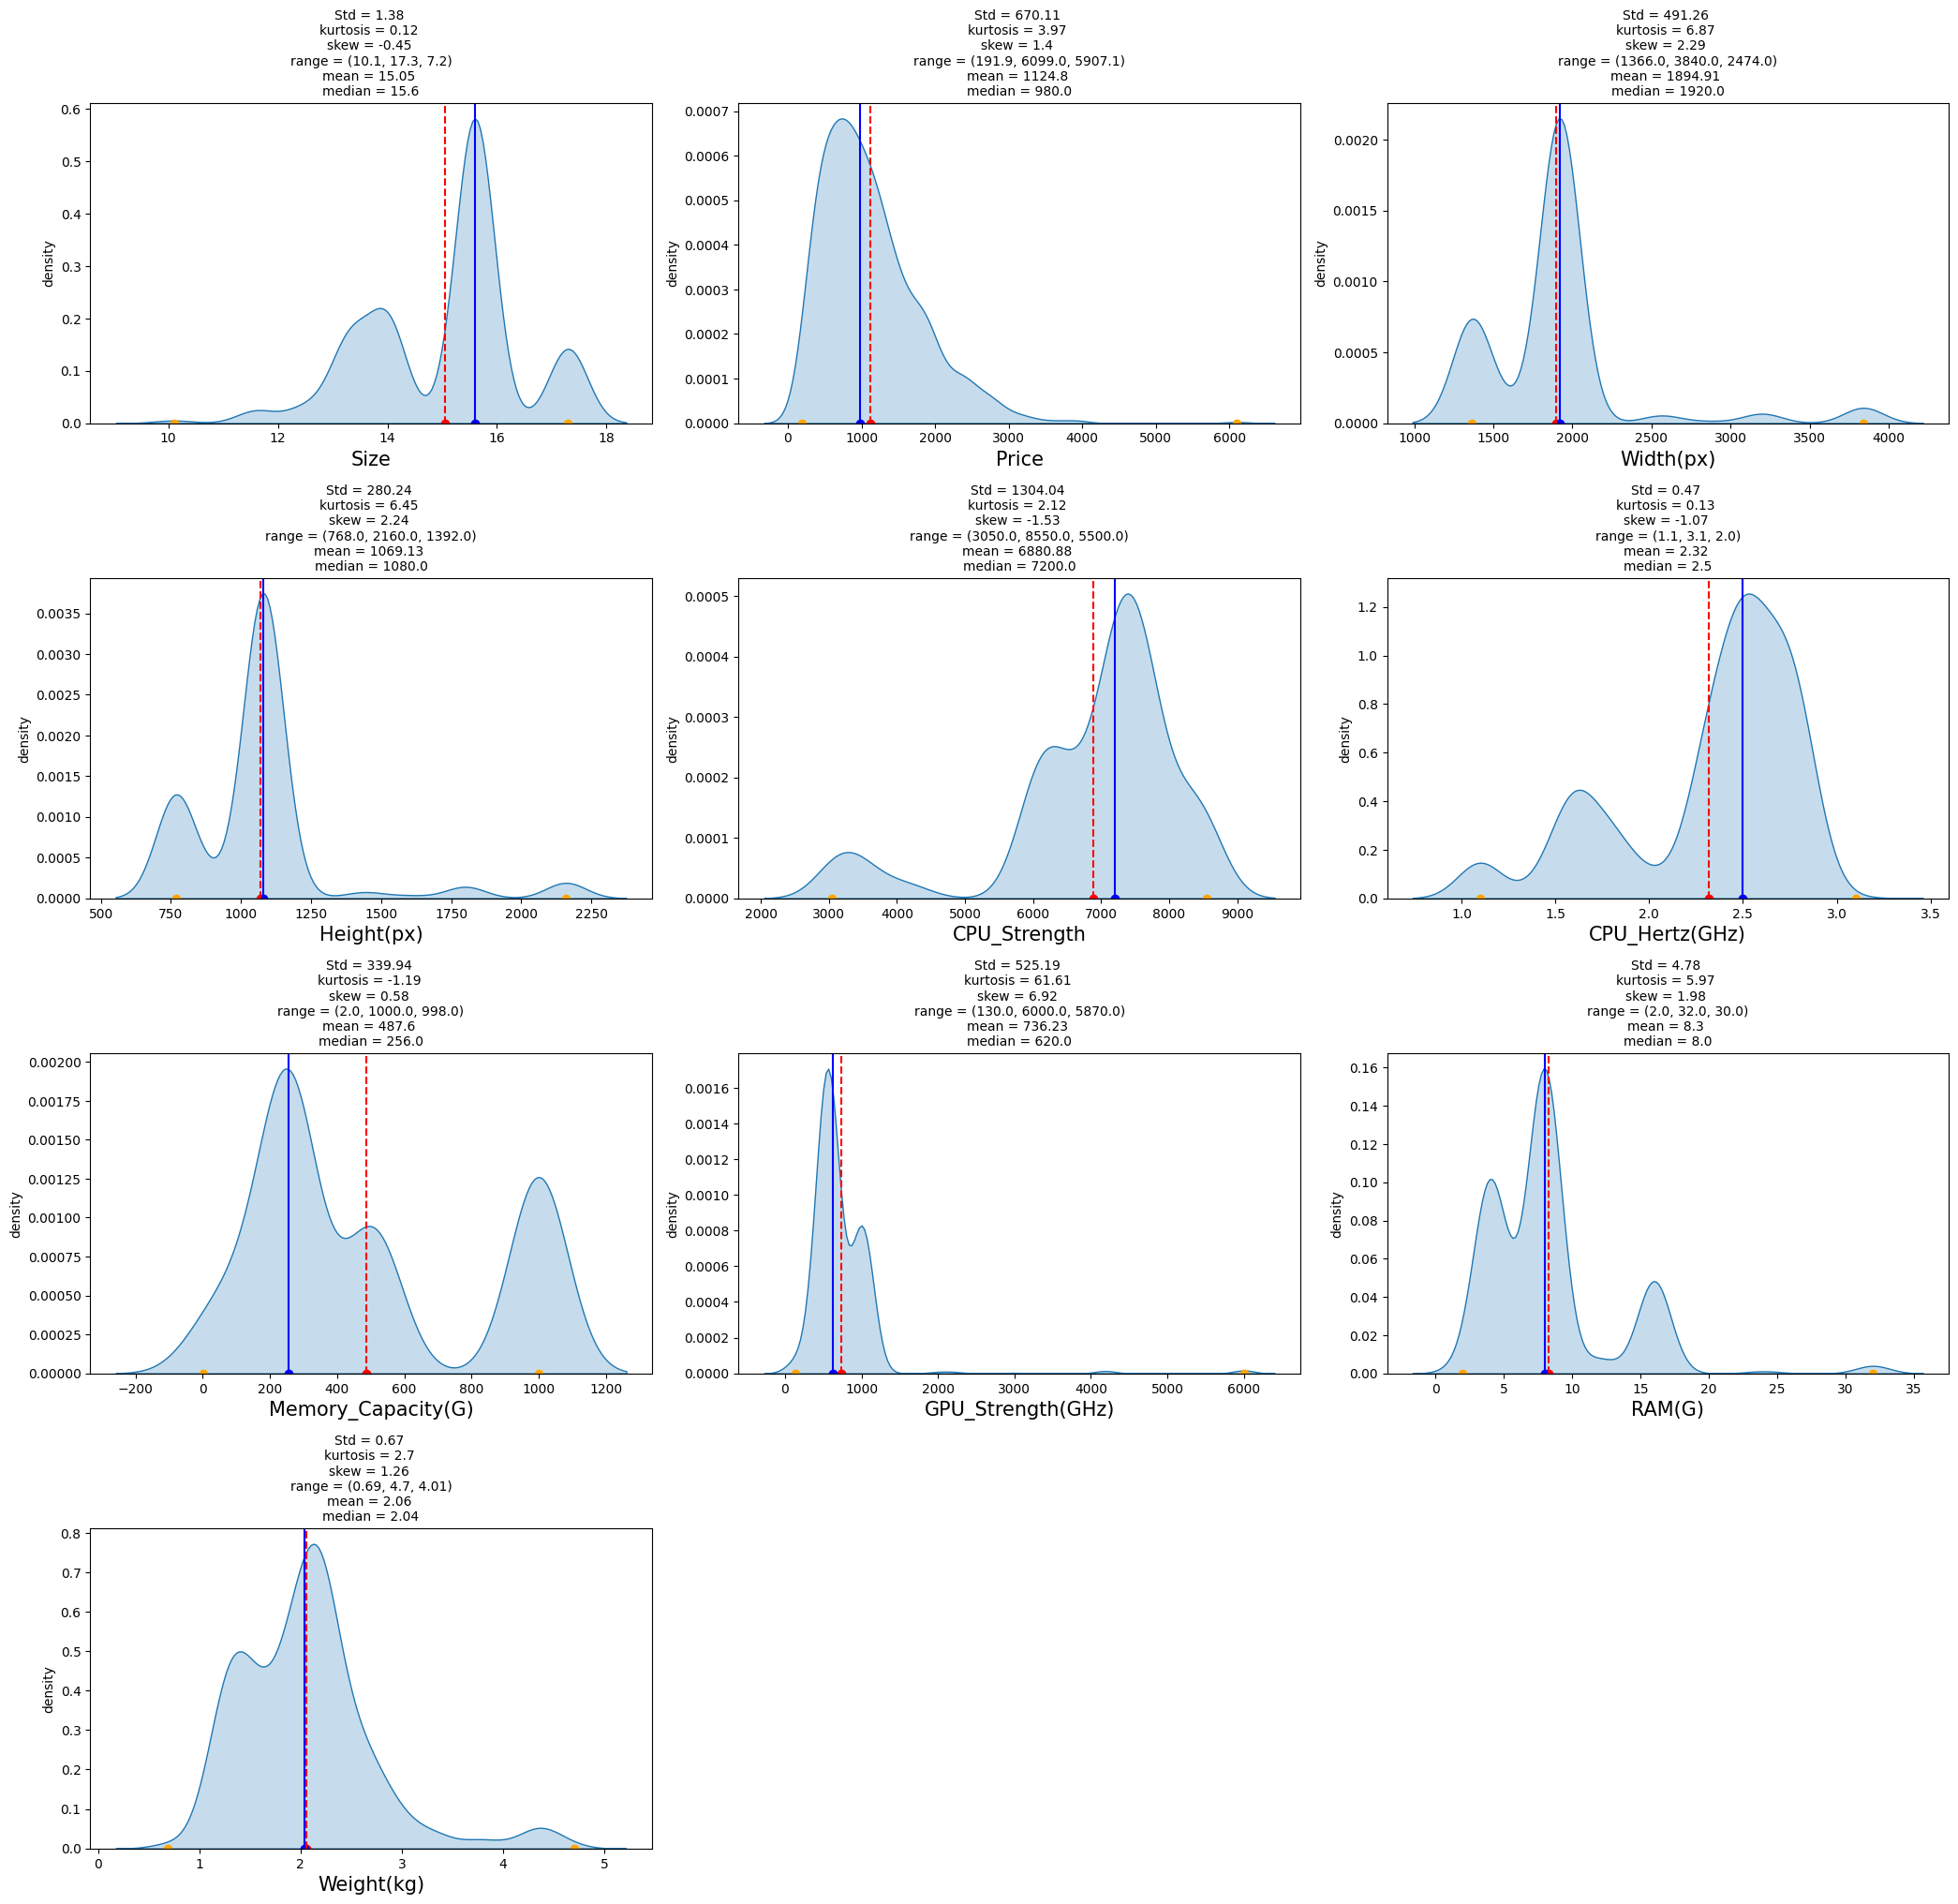

In [36]:
#Numerical
def UVA_qnt(data, var_group):
    size = len(var_group)
    plt.figure(figsize=(21, 25), dpi=100)

    # Looping for each variable
    for j, i in enumerate(var_group):
        # Calculating descriptives of the variable
        mini = data[i].min()
        maxi = data[i].max()
        ran = data[i].max() - data[i].min()
        mean = data[i].mean()
        median = data[i].median()
        st_dev = data[i].std()
        skew = data[i].skew()
        kurt = data[i].kurtosis()

        # Calculating points of standard deviation
        points = mean - st_dev, mean + st_dev

        # Plotting the variable with every information
        plt.subplot(5, 3, j + 1)  # Use a 5x3 grid
        sns.kdeplot(data[i], shade=True)
        plt.scatter([mini, maxi], [0, 0], color='orange', label="min/max")
        plt.scatter([mean], [0], color='red', label="mean")
        plt.scatter([median], [0], color='blue', label="median")
        plt.xlabel('{}'.format(i), fontsize=15)
        plt.ylabel('density')
        plt.axvline(mean, color='red', linestyle='dashed')
        plt.axvline(median, color='blue', linestyle='solid')
        plt.title('Std = {} \nkurtosis = {} \nskew = {} \nrange = {}\nmean = {} \nmedian = {}'.format(
            round(st_dev, 2),
            round(kurt, 2),
            round(skew, 2),
            (round(mini, 2), round(maxi, 2), round(ran, 2)),
            round(mean, 2),
            round(median, 2)
        ), fontsize=10)

    plt.tight_layout()
    plt.show()


qnt_var = df.select_dtypes(include=['int64','float64','Int64']).dtypes
qnt_list = ['Size',	'Price',	'Width(px)'	,'Height(px)' ,'CPU_Strength'	,'CPU_Hertz(GHz)', 'Memory_Capacity(G)', 'GPU_Strength(GHz)',	'RAM(G)',	'Weight(kg)']
UVA_qnt(df , qnt_list)

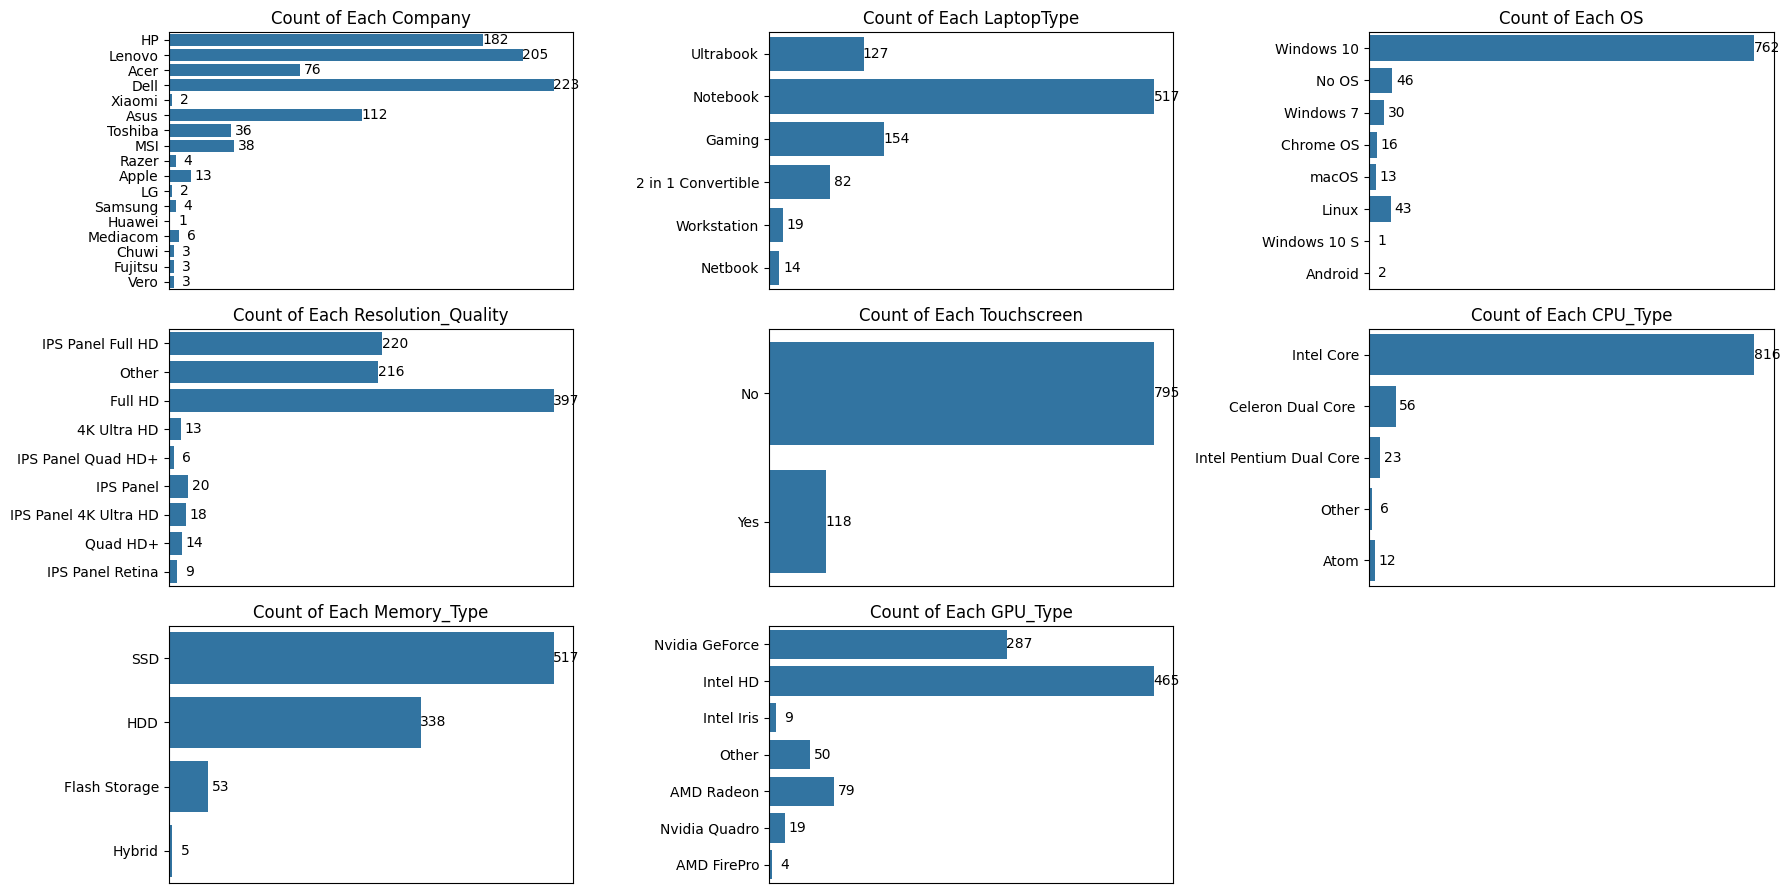

In [37]:
# Categorical

columns = ['Company'	,'LaptopType'	,'OS' ,'Resolution_Quality'	,'Touchscreen',	'CPU_Type', 'Memory_Type'	,'GPU_Type']

# Create subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(columns):
    ax = sns.countplot(data = df, y=col, ax=axes[i])
    ax.set_title(f'Count of Each {col}')
    ax.set_ylabel('')
    ax.set_xlabel('')

    # Remove the x-axis
    ax.xaxis.set_visible(False)

    # Add data labels on each bar
    for p in ax.patches:
        ax.annotate(format(p.get_width(), '.0f'),
                    (p.get_width(), p.get_y() + p.get_height() / 2.),
                    ha='center', va='center',
                    xytext=(9, 0),
                    textcoords='offset points')

# Hide the last empty subplot if there are any
if len(columns) < len(axes):
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##### **Bivariat Analysis**

Text(0.5, 1.0, '')

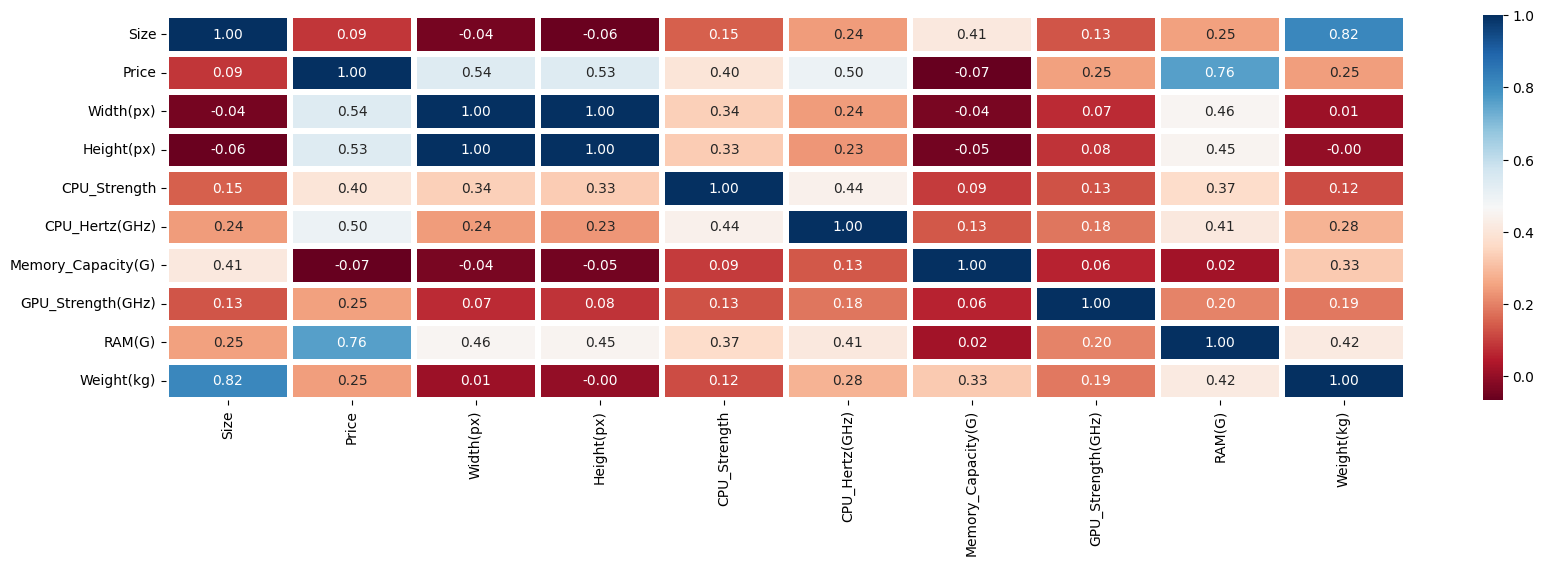

In [38]:
# Numerical vs Price
num_df = df.select_dtypes(include=['float64', 'Int64', 'int64'])

plt.figure(figsize=(20, 5), dpi=100)
correlation = num_df.corr(method='pearson')
sns.heatmap(correlation, annot=True, fmt=".2f", linewidth=3, cmap="RdBu")
plt.title('')

In [39]:
# categorical

## Null Hypothesis (H0): The means of the target variable is the same across all categories of the categorical variable. (Not Significant)
## Alternative Hypothesis (H1): At least one of the means is different. (Significant)

def perform_anova(df, num_col, cat_col, alpha=0.05):
    formula = f'{num_col} ~ C({cat_col})'
    model = ols(formula, data=df).fit()

    # Perform ANOVA
    anova_table = sm.stats.anova_lm(model, typ=2)

    # Extract p-value
    p_value = anova_table['PR(>F)'][0]

    # Print ANOVA table
    if p_value < alpha:
        print(f"'{cat_col}' is significant")
    else:
        print(f"'{cat_col}' is NOT significant")

    return p_value


p_value = round(perform_anova(df, 'Price', 'Company'), 10)
print(f"P-value: {p_value}")
print (" ")

p_value = round(perform_anova(df, 'Price', 'LaptopType'), 10)
print(f"P-value: {p_value}")
print (" ")

p_value = round(perform_anova(df, 'Price', 'OS'), 10)
print(f"P-value: {p_value}")
print (" ")

p_value = round(perform_anova(df, 'Price', 'Resolution_Quality'), 10)
print(f"P-value: {p_value}")
print (" ")

p_value = round(perform_anova(df, 'Price', 'Touchscreen'), 10)
print(f"P-value: {p_value}")
print (" ")

p_value = round(perform_anova(df, 'Price', 'CPU_Type'), 10)
print(f"P-value: {p_value}")
print (" ")

p_value = round(perform_anova(df, 'Price', 'Memory_Type'), 10)
print(f"P-value: {p_value}")
print (" ")

p_value = round(perform_anova(df, 'Price', 'GPU_Type'), 10)
print(f"P-value: {p_value}")
print (" ")

'Company' is significant
P-value: 0.0
 
'LaptopType' is significant
P-value: 0.0
 
'OS' is significant
P-value: 0.0
 
'Resolution_Quality' is significant
P-value: 0.0
 
'Touchscreen' is significant
P-value: 1.197e-07
 
'CPU_Type' is significant
P-value: 0.0
 
'Memory_Type' is significant
P-value: 0.0
 
'GPU_Type' is significant
P-value: 0.0
 


### **6-Handle Outlier**

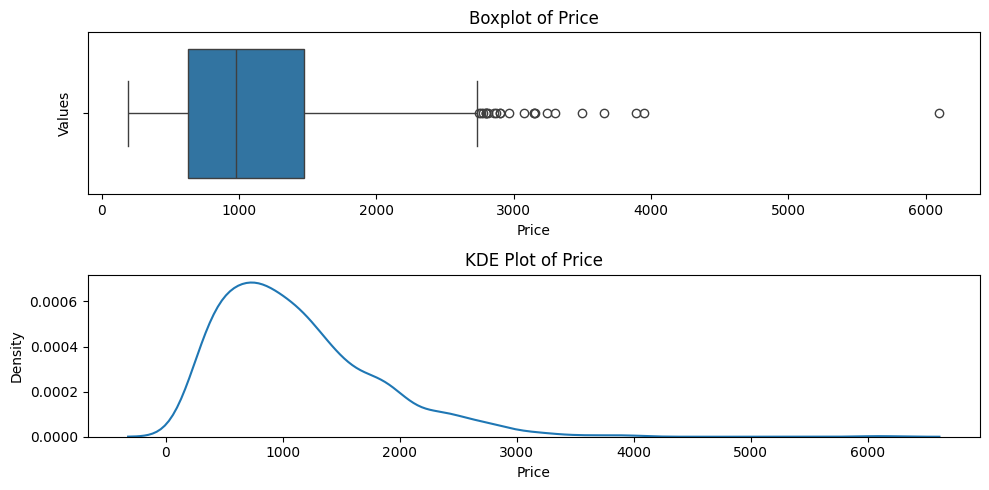

In [40]:
def box_plot_kde(data, column_name):
    if column_name not in data.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

    # Extract the column data
    column_data = data[column_name]

    # Boxplot
    sns.boxplot(x=column_data, ax=axes[0])
    axes[0].set_title(f'Boxplot of {column_name}')
    axes[0].set_xlabel(column_name)
    axes[0].set_ylabel('Values')

    # KDE Plot
    sns.kdeplot(x=column_data, ax=axes[1])
    axes[1].set_title(f'KDE Plot of {column_name}')
    axes[1].set_xlabel(column_name)

    plt.tight_layout()
    plt.show()

box_plot_kde(df, 'Price')

In [41]:
# Remove outlier

def remove_outliers_IQR(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_data = data[(data[col] > lower_bound) & (data[col] < upper_bound)]
    return filtered_data

print("Before outlier: ", df.shape)
df = remove_outliers_IQR(df, 'Price')
print("After outlier: ", df.shape)

Before outlier:  (913, 18)
After outlier:  (890, 18)


### **7-Modelling**

##### **Features and Target**

In [42]:
# Declare X , y

X = df.drop('Price', axis=1)
y = df['Price']

In [43]:
# Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42)

print("Total dataset: ", df.shape)
print(" ")
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print(" ")
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

Total dataset:  (890, 18)
 
X_train shape:  (712, 17)
y_train shape:  (712,)
 
X_test shape:  (178, 17)
y_test shape:  (178,)


##### **Modelling Pipeline**

In [44]:
# Numerical
numeric_pipe = Pipeline(
    steps=[
        ("Scaler", StandardScaler())
    ]
)

# Categorical
category_pipe = Pipeline(
    steps=[
        ("OneHot", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ]
)

# Combined
preprocessor = ColumnTransformer(
    transformers=[
        ("Categorical", category_pipe, ['Company', 'LaptopType', 'OS', 'Resolution_Quality', 'Touchscreen', 'CPU_Type', 'Memory_Type', 'GPU_Type']),  # Categorical features
        ("Numerical", numeric_pipe, ['Size', 'Width(px)', 'Height(px)', 'CPU_Strength', 'CPU_Hertz(GHz)', 'Memory_Capacity(G)', 'GPU_Strength(GHz)', 'RAM(G)', 'Weight(kg)'])  # Numerical features
    ]
)

# Estimator
def estimator(model):
    pipeline = Pipeline(
        steps=[
            ("Preprocessor", preprocessor),
            ("Model", model)
        ]
    )
    return pipeline

##### **Run Different Algorithms**

In [45]:
# List of all models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet Regression": ElasticNet(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror'),
    "Support Vector Regressor": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Multi-layer Perceptron": MLPRegressor()
}

In [46]:
for model_name, model in models.items():
    print(f"{model_name}")

    # Create pipeline
    pipeline = estimator(model)

    # Fit pipeline on training data
    pipeline.fit(X_train, y_train)

    # Predict on test data
    y_pred = pipeline.predict(X_test)

    # Calculate R2 score
    res = r2_score(y_test, y_pred)
    print(f"R2: {res:.4f}")

    # Cross-validation
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
    formatted_scores = [f"{score:.10f}" for score in scores]
    mean_cv_score = f"{scores.mean():.10f}"
    std_cv_score = f"{scores.std():.10f}"
    print(f"Standard deviation of CV R2 : {std_cv_score}")
    print(f"CV R2: {formatted_scores}")
    print(f"Final R2 (mean) : {mean_cv_score}\n")

Linear Regression
R2: 0.7640
Standard deviation of CV R2 : 133647911709086698176512.0000000000
CV R2: ['-30002131452739375333376.0000000000', '-7809707598818273394688.0000000000', '-342441577979841215463424.0000000000', '0.7729901741', '0.7177251840']
Final R2 (mean) : -76050683406279770112000.0000000000

Ridge Regression
R2: 0.7694
Standard deviation of CV R2 : 0.0272800684
CV R2: ['0.7751851708', '0.7109140875', '0.7413411698', '0.7735927711', '0.7162053635']
Final R2 (mean) : 0.7434477126

Lasso Regression
R2: 0.7744
Standard deviation of CV R2 : 0.0307565476
CV R2: ['0.7796062052', '0.7047943968', '0.7351601115', '0.7736361854', '0.7122015940']
Final R2 (mean) : 0.7410796986

ElasticNet Regression
R2: 0.7056
Standard deviation of CV R2 : 0.0249981190
CV R2: ['0.7059622168', '0.6382903080', '0.6537174655', '0.6714367607', '0.6402727942']
Final R2 (mean) : 0.6619359090

Decision Tree
R2: 0.7730
Standard deviation of CV R2 : 0.0304460318
CV R2: ['0.7464237502', '0.7003528213', '0.6762

In [47]:
pipeline

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(transformers=[('Categorical',
                                                  Pipeline(steps=[('OneHot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Company', 'LaptopType',
                                                   'OS', 'Resolution_Quality',
                                                   'Touchscreen', 'CPU_Type',
                                                   'Memory_Type', 'GPU_Type']),
                                                 ('Numerical',
                                                  Pipeline(steps=[('Scaler',
                                                                   StandardScaler())]),
                                                  ['Size', 'Width(px)',
                                                   'Height(px)', 'CPU_Strength',
                                                   'CPU_Hertz(GHz)',
                                                   'Memory_Capacity(G)',
                                                   'GPU_Strength(GHz)',
                                                   'RAM(G)', 'Weight(kg)'])])),
                ('Model', MLPRegressor())])

The result shows, we should choose `XGBoost` as the best model.

##### **HyperParameter Tunning Best Model**

In [48]:
#hyper parameter tunning
elit_model = xgb.XGBRegressor()

# Create the pipeline including preprocessing and the model
elit_pipeline = Pipeline([
    ("Preprocessor", preprocessor),
    ("Model", elit_model)
])

# Define the parameter grid for grid search
param_grid = {
    'Model__n_estimators': [100, 200, 300],
    'Model__max_depth': [3, 4, 5],
    'Model__learning_rate': [0.01, 0.1, 0.2]
}

# Perform grid search
grid_search = GridSearchCV(estimator=elit_pipeline, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best parameters from grid search
best_params = grid_search.best_params_

# Update the pipeline with the best parameters
elit_pipeline.set_params(**best_params)

# Fit the final pipeline on the training data
elit_pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = elit_pipeline.predict(X_test)

In [49]:
# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f"R2 after tunning: {r2:.10f}")

scores = cross_val_score(elit_pipeline, X, y, cv=5, scoring='r2')
formatted_scores = [f"{score:.10f}" for score in scores]
mean_cv_score_tunned = f"{scores.mean():.10f}"
std_cv_score = f"{scores.std():.10f}"
print(f"CV scores: {formatted_scores}")
print(f"R2 before tunning: {mean_cv_score_tunned}")

R2 after tunning: 0.8611058585
CV scores: ['0.8611541727', '0.8641520844', '0.8416359710', '0.8843758926', '0.8372555802']
R2 before tunning: 0.8577147402


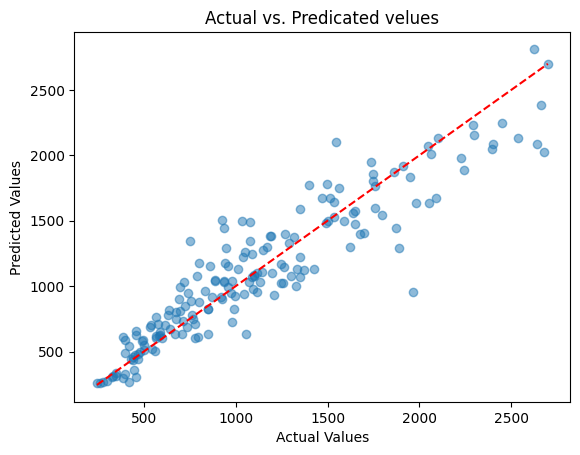

In [50]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicated velues')
plt.show()

##### **Final Pipeline**

In [51]:
## ALL PROCESS FOR DATA ENGINEERING

# 1-Drop Product Name------------
class ProductName_Dropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(['ProductName'], axis=1)

# 2-Add Width and Height----------
class Width_Height(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Resolution Display'] = X['ScreenResolution'].apply(self.Resolution_Display)
        X[['Width(px)', 'Height(px)']] = X['Resolution Display'].str.extract(r'(\d+)x(\d+)').astype(float)
        X = X.drop(['Resolution Display'], axis=1)
        return X
    def Resolution_Display(self, display_str):
        pattern = r'\b\d{3,4}x\d{3,4}\b'
        match = re.search(pattern, display_str)
        if match:
            return match.group(0)
        else:
            return 'Other'

# 3-Add Resolution Quality------------
class ResolutionQuality(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Resolution_Quality'] = X['ScreenResolution'].apply(self.Resolution_Quality)
        X = self.standardize_resolution_quality(X)
        return X
    def Resolution_Quality(self, display_str):
        keywords = []
        if '4K Ultra HD' in display_str:
            keywords.append('4K Ultra HD')
        if 'Full HD' in display_str:
            keywords.append('Full HD')
        if 'IPS Panel' in display_str:
            keywords.append('IPS Panel')
        if 'IPS Panel 4K Ultra HD' in display_str:
            keywords.append('IPS Panel 4K Ultra HD')
        if 'IPS Panel Full HD' in display_str:
            keywords.append('IPS Panel Full HD')
        if 'IPS Panel Quad HD+' in display_str:
            keywords.append('IPS Panel Quad HD+')
        if 'IPS Panel Retina Display' in display_str:
            keywords.append('IPS Panel Retina Display')
        if 'Quad HD+' in display_str:
            keywords.append('Quad HD+')
        return ', '.join(keywords) if keywords else 'Other'
    def standardize_resolution_quality(self, X):
        combinations = {
            '4K Ultra HD, IPS Panel, IPS Panel 4K Ultra HD': 'IPS Panel 4K Ultra HD',
            'Full HD, IPS Panel, IPS Panel Full HD': 'IPS Panel Full HD',
            'IPS Panel, IPS Panel Quad HD+, Quad HD+': 'IPS Panel Quad HD+',
            'IPS Panel, IPS Panel Retina Display': 'IPS Panel Retina'
        }
        for combination, desired_text in combinations.items():
            matching_index = X[X['Resolution_Quality'] == combination].index
            X.loc[matching_index, 'Resolution_Quality'] = desired_text
        return X

# 4-Add Touchscreen----------------
class Touchscreen(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Touchscreen'] = X['ScreenResolution'].apply(lambda x: 'Yes' if 'Touchscreen' in x else 'No')
        return X

# 5-Drop ScreenResolution-----------
class ScreenResolution_Dropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(['ScreenResolution'], axis=1)

# 6-Add CPU Type--------------------
class CPUType(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['CPU_Type'] = X['Cpu'].apply(self.CPU_Type)
        return X
    def CPU_Type(self, display_str):
        keywords = []
        if 'Atom' in display_str:
            keywords.append('Atom')
        if 'Celeron Dual Core' in display_str:
            keywords.append('Celeron Dual Core')
        if 'Intel Core' in display_str:
            keywords.append('Intel Core')
        if 'Pentium' in display_str:
            keywords.append('Intel Pentium Dual Core')
        return ', '.join(keywords) if keywords else 'Other'

# 7-Add CPU Strength-----------------
class CPUStrength(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['CPU_Strength'] = X['Cpu'].apply(self.CPU_Strength)
        # Convert the column to integer, handling cases where values might be None
        X['CPU_Strength'] = X['CPU_Strength'].astype('Int64')  # 'Int64' to handle NaN values as integers
        return X
    def CPU_Strength(self, description):
        match = re.search(r'\b\d{4}\b', description)
        return int(match.group(0)) if match else None

# 8- Add CPU Hertz------------------
class CPUHertz(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['CPU_Hertz(GHz)'] = X['Cpu'].apply(self.CPU_Hertz)
        return X
    def CPU_Hertz(self, description):
        match = re.search(r'(\d+\.\d+)GHz', description)
        return float(match.group(1)) if match else None

# 9-Drop cpu-----------------
class Cpu_Dropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(['Cpu'], axis=1)

# 10-Add memory Type-----------------------
class MemoryType(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Memory_Type'] = X['Memory'].apply(self.Memory_Type)
        return X
    def Memory_Type(self, description):
        match = re.search(r'\d+(\.\d+)?(GB|TB)\s*(.*)', description)
        return match.group(3).strip() if match else None

# 11- Add Memory Capacity--------------------
class MemoryCapacity(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Memory_Capacity(G)'] = X['Memory'].apply(self.Memory_Capacity)
        X['Memory_Capacity(G)'] = X['Memory_Capacity(G)'].astype('Int64')  # 'Int64' to handle NaN values as integers
        return X
    def Memory_Capacity(self, description):
        match = re.search(r'(\d+(\.\d+)?)\s*(GB|TB)', description)
        return float(match.group(1)) if match else None

# 12-Drop Memory-------------------------
class Memory_Dropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(['Memory'], axis=1)

# 13-Add Gpu Type----------------------
class GPUType(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['GPU_Type'] = X['Gpu'].apply(self.GPU_Type)
        return X
    def GPU_Type(self, display_str):
        keywords = []
        if 'FirePro' in display_str:
            keywords.append('AMD FirePro')
        if 'AMD Radeon' in display_str:
            keywords.append('AMD Radeon')
        if 'Intel HD' in display_str:
            keywords.append('Intel HD')
        if 'Iris' in display_str:
            keywords.append('Intel Iris')
        if 'GeForce' in display_str:
            keywords.append('Nvidia GeForce')
        if 'Quadro' in display_str:
            keywords.append('Nvidia Quadro')
        return ', '.join(keywords) if keywords else 'Other'

# 14-Add GPU Strength------------------------
class GPUStrength(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['GPU_Strength(GHz)'] = X['Gpu'].apply(self.GPU_Strength)
        return X
    def GPU_Strength(self, description):
        match = re.search(r'(\d+)$', description)
        return int(match.group(1)) if match else None

# 15-Drop Gpu-----------------------
class Gpu_Dropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(['Gpu'], axis=1)

# 16-Add RAM------------------------
class RAMM(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['RAM(G)'] = X['Ram'].apply(self.RAM)
        X['RAM(G)'] = X['RAM(G)'].astype('Int64')  # 'Int64' to handle NaN values as integers
        X = X.drop('Ram', axis=1)
        return X
    def RAM(self, description):
        match = re.search(r'(\d+(\.\d+)?)\s*(GB|TB)', description)
        return float(match.group(1)) if match else None

# 17-Add Weigth-----------------
class Weight(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Weight(kg)'] = X['Weight'].apply(self.Weight)
        X = X.drop('Weight', axis=1)
        return X
    def Weight(self, description):
        match = re.search(r'(\d+(\.\d+)?)\s*(kg)', description)
        return float(match.group(1)) if match else None

# 18-Change Column Name-----------------
class ColumnRenamer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns_to_rename = {
            "TypeName": "LaptopType",
            "OpSys": "OS",
            "Inches": "Size",
            "Price_euros": "Price",
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.rename(columns=self.columns_to_rename)
        X = X.reset_index(drop=True)
        return X

Now, we can add a new pipeline which is only for data enegineering

In [52]:
# Feature Engineering
engineering_pipe = Pipeline(
    steps=[
        ("ProductName_Dropper", ProductName_Dropper()),
        ("Width_Height", Width_Height()),
        ("ResolutionQuality", ResolutionQuality()),
        ("Touchscreen", Touchscreen()),
        ("ScreenResolution_Dropper", ScreenResolution_Dropper()),
        ("CPUType", CPUType()),
        ("CPUStrength", CPUStrength()),
        ("CPUHertz", CPUHertz()),
        ("Cpu_Dropper", Cpu_Dropper()),
        ("MemoryType", MemoryType()),
        ("MemoryCapacity", MemoryCapacity()),
        ("Memory_Dropper", Memory_Dropper()),
        ("GPUType", GPUType()),
        ("GPUStrength", GPUStrength()),
        ("Gpu_Dropper", Gpu_Dropper()),
        ("RAMM", RAMM()),
        ("Weight", Weight()),
        ("ColumnRenamer", ColumnRenamer()),
        ])

In [53]:
elit_pipeline

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(transformers=[('Categorical',
                                                  Pipeline(steps=[('OneHot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Company', 'LaptopType',
                                                   'OS', 'Resolution_Quality',
                                                   'Touchscreen', 'CPU_Type',
                                                   'Memory_Type', 'GPU_Type']),
                                                 ('Numerical',
                                                  Pipeline(steps=[('Scaler',
                                                                   StandardScaler())]),
                                                  ['Size', 'Width(px)',
                                                   'Height(p...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

### **8-Make Prediction**

In [60]:
# Load New data ans reset index
unseen_df = unseen_df.reset_index(drop=True)

# Drop the column price (if it has)
new_df = unseen_df.drop(['Price_euros'], axis=1)

# Run Data Engineering Process
new_df_transformed = engineering_pipe.fit_transform(new_df)

# Run Model and Make Prediction
prediction = elit_pipeline.predict(new_df_transformed)

# Add prediction column to new dataset
new_df['Predictions'] = prediction

new_df.head(5)

,Company,ProductName,TypeName,ScreenResolution,Cpu,Memory,Gpu,OpSys,Ram,Weight,Inches,Predictions
0,Mediacom,SmartBook 140,Notebook,Full HD / 1920x1080,Atom 8350 1.44GHz,32GB Flash Storage,Intel HD Graphics 400,Windows 10,2GB,1.4kg,14.0,217.489151
1,Acer,C740-C9QX (3205U/2GB/32GB/Chrome,Netbook,1366x768,Celeron Dual Core 3205 1.5GHz,32GB SSD,Intel HD Graphics 400,Chrome OS,2GB,1.3kg,11.6,413.815674
2,Acer,Chromebook C910-C2ST,Notebook,1366x768,Celeron Dual Core 3205 1.5GHz,16GB SSD,Intel HD Graphics 400,Chrome OS,2GB,2.19kg,15.6,298.364288
3,Acer,TravelMate B117-M,Netbook,1366x768,Celeron Dual Core 3050 1.6GHz,32GB Flash Storage,Intel HD Graphics 400,Windows 10,4GB,1.4kg,11.6,497.012817
4,Asus,X553SA-XX021T (N3050/4GB/500GB/W10),Notebook,1366x768,Celeron Dual Core 3050 1.6GHz,500GB HDD,Intel HD Graphics 400,Windows 10,4GB,2.2kg,15.6,366.399200


In [62]:
#Analyze performance of Model

orginial_df = unseen_df['Price_euros']
predicted_df = new_df['Predictions']

# Combine columns into a new DataFrame
new_dataframe = pd.DataFrame({
    'Price_euros': orginial_df,
    'Predictions': predicted_df
})

new_dataframe.head()

,Price_euros,Predictions
0,239.0,217.489151
1,174.0,413.815674
2,199.0,298.364288
3,269.0,497.012817
4,369.0,366.399200


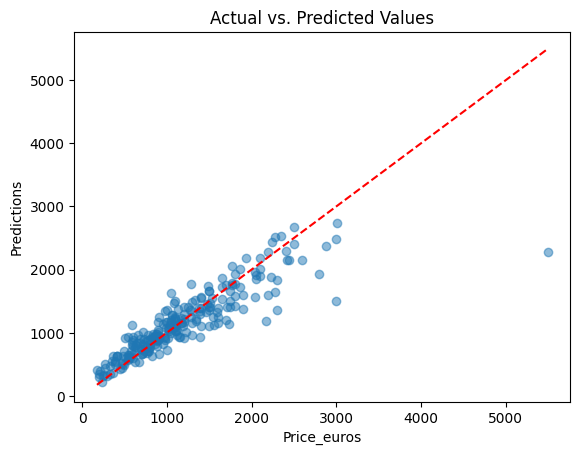

In [66]:
y_test = new_dataframe['Price_euros']
y_pred = new_dataframe['Predictions']

# Create scatter plot
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', linestyle='--')
plt.xlabel('Price_euros')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted Values')
plt.show()

In [67]:
new_dataframe.loc[new_dataframe['Price_euros'] > 5000].index.tolist()

[206]